# Synthetic Data Generation Using RAGAS - RAG Evaluation with LangSmith

In the following notebook we'll explore a use-case for RAGAS' synthetic testset generation workflow!



- 🤝 BREAKOUT ROOM #1
  1. Use RAGAS to Generate Synthetic Data

- 🤝 BREAKOUT ROOM #2
  1. Load them into a LangSmith Dataset
  2. Evaluate our RAG chain against the synthetic test data
  3. Make changes to our pipeline
  4. Evaluate the modified pipeline

SDG is a critical piece of the puzzle, especially for early iteration! Without it, it would not be nearly as easy to get high quality early signal for our application's performance.

Let's dive in!

# 🤝 BREAKOUT ROOM #1

## Task 1: Dependencies and API Keys

We'll need to install a number of API keys and dependencies, since we'll be leveraging a number of great technologies for this pipeline!

1. OpenAI's endpoints to handle the Synthetic Data Generation
2. OpenAI's Endpoints for our RAG pipeline and LangSmith evaluation
3. QDrant as our vectorstore
4. LangSmith for our evaluation coordinator!

Let's install and provide all the required information below!

## Dependencies and API Keys:

> NOTE: DO NOT RUN THESE CELLS IF YOU ARE RUNNING THIS NOTEBOOK LOCALLY

In [ ]:
#!pip install -qU ragas==0.2.10

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 175.7/175.7 kB 8.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.5/45.5 kB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 71.1/71.1 kB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 24.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 68.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 48.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 411.6/411.6 kB 27.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.9/50.9 kB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 454.8/454.8 kB 28.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 50.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 8.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 14.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/1

In [ ]:
#!pip install -qU langchain-community==0.3.14 langchain-openai==0.2.14 unstructured==0.16.12 langgraph==0.2.61 langchain-qdrant==0.2.0

### NLTK Import

To prevent errors that may occur based on OS - we'll import NLTK and download the needed packages to ensure correct handling of data.

In [1]:
import nltk
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package punkt to /home/caleb/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/caleb/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

In [2]:
import os
import getpass

os.environ["LANGCHAIN_TRACING_V2"] = "true"
# os.environ["LANGCHAIN_API_KEY"] = getpass.getpass("LangChain API Key:")

We'll also want to set a project name to make things easier for ourselves.

In [3]:
from uuid import uuid4

os.environ["LANGCHAIN_PROJECT"] = f"AIM - SDG - {uuid4().hex[0:8]}"

OpenAI's API Key!

In [4]:
os.environ["OPENAI_API_KEY"] = getpass.getpass("OpenAI API Key:")

## Generating Synthetic Test Data

We wil be using Ragas to build out a set of synthetic test questions, references, and reference contexts. This is useful because it will allow us to find out how our system is performing.

> NOTE: Ragas is best suited for finding *directional* changes in your LLM-based systems. The absolute scores aren't comparable in a vacuum.

### Data Preparation

We'll prepare our data - and download our webpages which we'll be using for our data today.

These webpages are from [Simon Willison's](https://simonwillison.net/) yearly "AI learnings".

- [2023 Blog](https://simonwillison.net/2023/Dec/31/ai-in-2023/)
- [2024 Blog](https://simonwillison.net/2024/Dec/31/llms-in-2024/)

Let's start by collecting our data into a useful pile!

In [5]:
!mkdir data

mkdir: cannot create directory ‘data’: File exists


In [6]:
!curl https://simonwillison.net/2023/Dec/31/ai-in-2023/ -o data/2023_llms.html

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 31493    0 31493    0     0   219k      0 --:--:-- --:--:-- --:--:--  221k


In [7]:
!curl https://simonwillison.net/2024/Dec/31/llms-in-2024/ -o data/2024_llms.html

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 70519    0 70519    0     0   499k      0 --:--:-- --:--:-- --:--:--  502k


Next, let's load our data into a familiar LangChain format using the `DirectoryLoader`.

In [4]:
from langchain_community.document_loaders import DirectoryLoader

path = "data/"
loader = DirectoryLoader(path, glob="*.html")
docs = loader.load()

### Knowledge Graph Based Synthetic Generation

Ragas uses a knowledge graph based approach to create data. This is extremely useful as it allows us to create complex queries rather simply. The additional testset complexity allows us to evaluate larger problems more effectively, as systems tend to be very strong on simple evaluation tasks.

Let's start by defining our `generator_llm` (which will generate our questions, summaries, and more), and our `generator_embeddings` which will be useful in building our graph.

### Unrolled SDG

In [5]:
from ragas.llms import LangchainLLMWrapper
from ragas.embeddings import LangchainEmbeddingsWrapper
from langchain_openai import ChatOpenAI
from langchain_openai import OpenAIEmbeddings
generator_llm = LangchainLLMWrapper(ChatOpenAI(model="gpt-4.1-nano"))
generator_embeddings = LangchainEmbeddingsWrapper(OpenAIEmbeddings())

Next, we're going to instantiate our Knowledge Graph.

This graph will contain N number of nodes that have M number of relationships. These nodes and relationships (AKA "edges") will define our knowledge graph and be used later to construct relevant questions and responses.

In [6]:
from ragas.testset.graph import KnowledgeGraph

kg = KnowledgeGraph()
kg

KnowledgeGraph(nodes: 0, relationships: 0)

The first step we're going to take is to simply insert each of our full documents into the graph. This will provide a base that we can apply transformations to.

In [7]:
from ragas.testset.graph import Node, NodeType

for doc in docs:
    kg.nodes.append(
        Node(
            type=NodeType.DOCUMENT,
            properties={"page_content": doc.page_content, "document_metadata": doc.metadata}
        )
    )
kg

KnowledgeGraph(nodes: 2, relationships: 0)

Now, we'll apply the *default* transformations to our knowledge graph. This will take the nodes currently on the graph and transform them based on a set of [default transformations](https://docs.ragas.io/en/latest/references/transforms/#ragas.testset.transforms.default_transforms).

These default transformations are dependent on the corpus length, in our case:

- Producing Summaries -> produces summaries of the documents
- Extracting Headlines -> finding the overall headline for the document
- Theme Extractor -> extracts broad themes about the documents

It then uses cosine-similarity and heuristics between the embeddings of the above transformations to construct relationships between the nodes.

In [8]:
from ragas.testset.transforms import default_transforms, apply_transforms

transformer_llm = generator_llm
embedding_model = generator_embeddings

default_transforms = default_transforms(documents=docs, llm=transformer_llm, embedding_model=embedding_model)
apply_transforms(kg, default_transforms)
kg

Applying HeadlinesExtractor:   0%|          | 0/2 [00:00<?, ?it/s]

Applying HeadlineSplitter:   0%|          | 0/2 [00:00<?, ?it/s]

Applying SummaryExtractor:   0%|          | 0/2 [00:00<?, ?it/s]

Applying CustomNodeFilter:   0%|          | 0/12 [00:00<?, ?it/s]

Applying [EmbeddingExtractor, ThemesExtractor, NERExtractor]:   0%|          | 0/18 [00:00<?, ?it/s]

unable to apply transformation: 'StringIO' object has no attribute 'output'


Applying [CosineSimilarityBuilder, OverlapScoreBuilder]:   0%|          | 0/2 [00:00<?, ?it/s]

KnowledgeGraph(nodes: 10, relationships: 33)

We can save and load our knowledge graphs as follows.

In [9]:
kg.save("ai_across_years_kg.json")
ai_across_years_kg = KnowledgeGraph.load("ai_across_years_kg.json")
ai_across_years_kg

KnowledgeGraph(nodes: 10, relationships: 33)

Using our knowledge graph, we can construct a "test set generator" - which will allow us to create queries.

In [10]:
from ragas.testset import TestsetGenerator

generator = TestsetGenerator(llm=generator_llm, embedding_model=embedding_model, knowledge_graph=ai_across_years_kg)

However, we'd like to be able to define the kinds of queries we're generating - which is made simple by Ragas having pre-created a number of different "QuerySynthesizer"s.

Each of these Synthetsizers is going to tackle a separate kind of query which will be generated from a scenario and a persona.

In essence, Ragas will use an LLM to generate a persona of someone who would interact with the data - and then use a scenario to construct a question from that data and persona.

In [11]:
from ragas.testset.synthesizers import default_query_distribution, SingleHopSpecificQuerySynthesizer, MultiHopAbstractQuerySynthesizer, MultiHopSpecificQuerySynthesizer

query_distribution = [
        (SingleHopSpecificQuerySynthesizer(llm=generator_llm), 0.5),
        (MultiHopAbstractQuerySynthesizer(llm=generator_llm), 0.25),
        (MultiHopSpecificQuerySynthesizer(llm=generator_llm), 0.25),
]

#### ❓ Question #1:

What are the three types of query synthesizers doing? Describe each one in simple terms.

#### Answer:

SingleHopSpecificQuerySynthesizer: Generates straightforward, fact-based questions that can be answered using a single piece of information (a single "hop") from the context.

MultiHopAbstractQuerySynthesizer: Generates more complex, higher-level questions that require connecting multiple pieces of information (multiple "hops").

MultiHopSpecificQuerySynthesizer: Generates detailed, specific questions that require combining information from several parts of the context (multiple "hops") to answer, but the questions are still focused on concrete facts or events.


Finally, we can use our `TestSetGenerator` to generate our testset!

In [12]:
testset = generator.generate(testset_size=10, query_distribution=query_distribution)
testset.to_pandas()

Generating personas:   0%|          | 0/2 [00:00<?, ?it/s]

Generating Scenarios:   0%|          | 0/3 [00:00<?, ?it/s]

Generating Samples:   0%|          | 0/11 [00:00<?, ?it/s]

,user_input,reference_contexts,reference,synthesizer_name
0,What is the significance of Meta in the contex...,[Things we learned about LLMs in 2024 31st Dec...,Meta is mentioned as one of the organizations ...,single_hop_specifc_query_synthesizer
1,Wha is GPT-4 and how does it relate to the AI ...,[punch massively above their weight. I run Lla...,The context mentions GPT-4 as part of the disc...,single_hop_specifc_query_synthesizer
2,What is Skye in the context of the AI models d...,[models. The demo also sounded conspicuously s...,"In the context provided, Skye is the name of a...",single_hop_specifc_query_synthesizer
3,What role does Meta play in the development of...,"[on inference. The sequel to o1, o3 (they skip...",Meta published a relevant paper titled 'Traini...,single_hop_specifc_query_synthesizer
4,What are the recent developments and implicati...,[Simon Willison’s Weblog Subscribe Things we l...,Simon Willison’s 2024 review highlights that t...,single_hop_specifc_query_synthesizer
5,how important is training data quality and qua...,[<1-hop>\n\nThe ethics of this space remain di...,the context explains that the most important f...,multi_hop_abstract_query_synthesizer
6,How do the recent advancements in large langua...,[<1-hop>\n\nThings we learned about LLMs in 20...,"In 2024, large language models (LLMs) saw sign...",multi_hop_abstract_query_synthesizer
7,how advancments in LLMs 2024 and synthetic dat...,[<1-hop>\n\nThings we learned about LLMs in 20...,"In 2024, there were many advancments in LLMs l...",multi_hop_abstract_query_synthesizer
8,H0w do the meta themes in the context of LLMs ...,[<1-hop>\n\nThe ethics of this space remain di...,The context highlights that Meta released Llam...,multi_hop_specific_query_synthesizer
9,Based on the detailed explanations of LLMs and...,[<1-hop>\n\nthe document includes some of the ...,The context highlights that while the document...,multi_hop_specific_query_synthesizer


### Abstracted SDG

The above method is the full process - but we can shortcut that using the provided abstractions!

This will generate our knowledge graph under the hood, and will - from there - generate our personas and scenarios to construct our queries.



In [13]:
from ragas.testset import TestsetGenerator

generator = TestsetGenerator(llm=generator_llm, embedding_model=generator_embeddings)
dataset = generator.generate_with_langchain_docs(docs, testset_size=10)

Applying HeadlinesExtractor:   0%|          | 0/2 [00:00<?, ?it/s]

Applying HeadlineSplitter:   0%|          | 0/2 [00:00<?, ?it/s]

Applying SummaryExtractor:   0%|          | 0/2 [00:00<?, ?it/s]

Applying CustomNodeFilter:   0%|          | 0/12 [00:00<?, ?it/s]

Applying [EmbeddingExtractor, ThemesExtractor, NERExtractor]:   0%|          | 0/16 [00:00<?, ?it/s]

unable to apply transformation: 'StringIO' object has no attribute 'output'


Applying [CosineSimilarityBuilder, OverlapScoreBuilder]:   0%|          | 0/2 [00:00<?, ?it/s]

Generating personas:   0%|          | 0/2 [00:00<?, ?it/s]

Generating Scenarios:   0%|          | 0/3 [00:00<?, ?it/s]

Generating Samples:   0%|          | 0/12 [00:00<?, ?it/s]

In [14]:
dataset.to_pandas()

,user_input,reference_contexts,reference,synthesizer_name
0,Google what is?,[Things we learned about LLMs in 2024 31st Dec...,The context mentions Google in relation to its...,single_hop_specifc_query_synthesizer
1,How does Google relate to the term in the cont...,[punch massively above their weight. I run Lla...,"In the provided context, Google is mentioned a...",single_hop_specifc_query_synthesizer
2,What is Prince Canuma's opinion on Apple Intel...,[acknowledge that. If you tell me that you are...,Prince Canuma states that Apple Intelligence i...,single_hop_specifc_query_synthesizer
3,What is Qwen in the context of large language ...,[Simon Willison’s Weblog Subscribe Things we l...,Qwen is mentioned as a term related to large l...,single_hop_specifc_query_synthesizer
4,Hw can the enviromental impact of LLM devlopme...,[<1-hop>\n\nThings we learned about LLMs in 20...,"The context explains that in 2024, the environ...",multi_hop_abstract_query_synthesizer
5,How does the increased accessibility of LLMs o...,[<1-hop>\n\nThings we learned about LLMs in 20...,"The context highlights that in 2024, models li...",multi_hop_abstract_query_synthesizer
6,"how AI capabilities like question answering, s...",[<1-hop>\n\nThe ethics of this space remain di...,The context explains that Large Language Model...,multi_hop_abstract_query_synthesizer
7,Considering the significant advancements in lo...,[<1-hop>\n\nThings we learned about LLMs in 20...,"In 2024, the development of long-input models ...",multi_hop_abstract_query_synthesizer
8,What does the context reveal about Apple's app...,[<1-hop>\n\nSimon Willison’s Weblog Subscribe ...,The context indicates that Apple’s MLX library...,multi_hop_specific_query_synthesizer
9,How do the themes of Meta relate to the recent...,[<1-hop>\n\nThings we learned about LLMs in 20...,The context highlights significant progress in...,multi_hop_specific_query_synthesizer


We'll need to provide our LangSmith API key, and set tracing to "true".

# 🤝 BREAKOUT ROOM #2

## Task 4: LangSmith Dataset

Now we can move on to creating a dataset for LangSmith!

First, we'll need to create a dataset on LangSmith using the `Client`!

We'll name our Dataset to make it easy to work with later.

In [15]:
from langsmith import Client

client = Client()

dataset_name = "State of AI Across the Years!"

langsmith_dataset = client.create_dataset(
    dataset_name=dataset_name,
    description="State of AI Across the Years!"
)

We'll iterate through the RAGAS created dataframe - and add each example to our created dataset!

> NOTE: We need to conform the outputs to the expected format - which in this case is: `question` and `answer`.

In [16]:
for data_row in dataset.to_pandas().iterrows():
  client.create_example(
      inputs={
          "question": data_row[1]["user_input"]
      },
      outputs={
          "answer": data_row[1]["reference"]
      },
      metadata={
          "context": data_row[1]["reference_contexts"]
      },
      dataset_id=langsmith_dataset.id
  )

## Basic RAG Chain

Time for some RAG!


In [17]:
rag_documents = docs

To keep things simple, we'll just use LangChain's recursive character text splitter!


In [18]:
from langchain.text_splitter import RecursiveCharacterTextSplitter

text_splitter = RecursiveCharacterTextSplitter(
    chunk_size = 500,
    chunk_overlap = 50
)

rag_documents = text_splitter.split_documents(rag_documents)

We'll create our vectorstore using OpenAI's [`text-embedding-3-small`](https://platform.openai.com/docs/guides/embeddings/embedding-models) embedding model.

In [19]:
from langchain_openai import OpenAIEmbeddings

embeddings = OpenAIEmbeddings(model="text-embedding-3-small")

As usual, we will power our RAG application with Qdrant!

In [20]:
from langchain_community.vectorstores import Qdrant

vectorstore = Qdrant.from_documents(
    documents=rag_documents,
    embedding=embeddings,
    location=":memory:",
    collection_name="State of AI"
)

/home/caleb/projects/AIE6/07_Synthetic_Data_Generation_and_LangSmith/.venv/lib/python3.13/site-packages/qdrant_client/http/models/models.py:758: SyntaxWarning: invalid escape sequence '\&'
  description="Check that the field is empty, alternative syntax for `is_empty: \&quot;field_name\&quot;`",
/home/caleb/projects/AIE6/07_Synthetic_Data_Generation_and_LangSmith/.venv/lib/python3.13/site-packages/qdrant_client/http/models/models.py:762: SyntaxWarning: invalid escape sequence '\&'
  description="Check that the field is null, alternative syntax for `is_null: \&quot;field_name\&quot;`",


In [21]:
retriever = vectorstore.as_retriever(search_kwargs={"k": 10})

To get the "A" in RAG, we'll provide a prompt.

In [22]:
from langchain.prompts import ChatPromptTemplate

RAG_PROMPT = """\
Given a provided context and question, you must answer the question based only on context.

If you cannot answer the question based on the context - you must say "I don't know".

Context: {context}
Question: {question}
"""

rag_prompt = ChatPromptTemplate.from_template(RAG_PROMPT)

For our LLM, we will be using TogetherAI's endpoints as well!

We're going to be using Meta Llama 3.1 70B Instruct Turbo - a powerful model which should get us powerful results!

In [23]:
from langchain_openai import ChatOpenAI

llm = ChatOpenAI(model="gpt-4.1-mini")

Finally, we can set-up our RAG LCEL chain!

In [24]:
from operator import itemgetter
from langchain_core.runnables import RunnablePassthrough, RunnableParallel
from langchain.schema import StrOutputParser

rag_chain = (
    {"context": itemgetter("question") | retriever, "question": itemgetter("question")}
    | rag_prompt | llm | StrOutputParser()
)

In [25]:
rag_chain.invoke({"question" : "What are Agents?"})

'Based on the context provided, "agents" is an infuriatingly vague term without a single, clear, and widely understood meaning. Generally, it seems to refer to AI systems that can act on your behalf, sometimes described as either:\n\n- AI entities that "go and act on your behalf" akin to a travel agent model.\n- Large Language Models (LLMs) given access to tools which they can run iteratively to solve problems.\n\nHowever, the term lacks a consistent definition, and many definitions (211 collected on Twitter) exist, reflecting widespread ambiguity. The concept of agents feels perpetually "coming soon," with few if any examples running in production. Their utility is currently hindered by challenges such as LLMs\' gullibility (their tendency to believe everything told to them), and the difficulty of achieving robust autonomous decision-making which may require advanced capabilities near Artificial General Intelligence (AGI).\n\nIn summary, agents are AI systems intended to act autonomou

## LangSmith Evaluation Set-up

We'll use OpenAI's GPT-4.1 as our evaluation LLM for our base Evaluators.

In [26]:
eval_llm = ChatOpenAI(model="gpt-4.1")

We'll be using a number of evaluators - from LangSmith provided evaluators, to a few custom evaluators!

In [27]:
from langsmith.evaluation import LangChainStringEvaluator, evaluate

qa_evaluator = LangChainStringEvaluator("qa", config={"llm" : eval_llm})

labeled_helpfulness_evaluator = LangChainStringEvaluator(
    "labeled_criteria",
    config={
        "criteria": {
            "helpfulness": (
                "Is this submission helpful to the user,"
                " taking into account the correct reference answer?"
            )
        },
        "llm" : eval_llm
    },
    prepare_data=lambda run, example: {
        "prediction": run.outputs["output"],
        "reference": example.outputs["answer"],
        "input": example.inputs["question"],
    }
)

dope_or_nope_evaluator = LangChainStringEvaluator(
    "criteria",
    config={
        "criteria": {
            "dopeness": "Is this submission dope, lit, or cool?",
        },
        "llm" : eval_llm
    }
)

#### 🏗️ Activity #2:

Highlight what each evaluator is evaluating.

- `qa_evaluator`:
- `labeled_helpfulness_evaluator`:
- `dope_or_nope_evaluator`:

#### Answer:

qa_evaluator: checks the correctness of the model’s answer. It compares the model’s output to the reference answer (the “ground truth”) and determines if the answer is factually correct and directly addresses the question.

labeled_helpfulness_evaluator: measures helpfulness. It asks: “Is this submission helpful to the user, taking into account the correct reference answer?” It evaluates whether the answer is useful, clear, and provides value to the user, not just if it is correct.

dope_or_nope_evaluator: checks for “dopeness”—in other words, whether the answer is “dope, lit, or cool.” It’s a subjective, style-focused metric that evaluates if the answer is engaging, interesting, or has a “cool” factor, beyond just being correct or helpful.

## LangSmith Evaluation

In [28]:
evaluate(
    rag_chain.invoke,
    data=dataset_name,
    evaluators=[
        qa_evaluator,
        labeled_helpfulness_evaluator,
        dope_or_nope_evaluator
    ],
    metadata={"revision_id": "default_chain_init"},
)

View the evaluation results for experiment: 'dear-passenger-56' at:
https://smith.langchain.com/o/1bd08012-acb3-40ba-875b-6293ab3a9e74/datasets/3f536954-6327-4905-90ff-302ec291c937/compare?selectedSessions=37d17d91-5ae1-481d-ad77-76f53422a0e9




0it [00:00, ?it/s]

,inputs.question,outputs.output,error,reference.answer,feedback.correctness,feedback.helpfulness,feedback.dopeness,execution_time,example_id,id
0,How does googl compare to other companies like...,I don't know.,None,"In 2024, Google has made significant advanceme...",0,0,0,0.879190,d0b7af52-5a46-4086-b733-d19b8c19df07,4c6cc403-0ba3-4639-85ea-eb08396ab5b2
1,How have recent advancements in Large Language...,Recent advancements in Large Language Models (...,None,"In 2024, advancements in Large Language Models...",1,1,0,4.786098,878cac42-89f5-40ef-b5e9-23f8128be21c,0c49b3f4-af31-4759-9776-8b763baaf4f2
2,How do the themes of Meta relate to the recent...,"Based on the provided context, Meta is involve...",None,The context highlights significant progress in...,1,0,0,11.958296,414d957b-1c88-4f56-89d5-f936fdfd5fec,3eea1030-374b-4c4e-9b25-8bec49fa301e
3,What does the context reveal about Apple's app...,The context reveals that Apple’s approach to A...,None,The context indicates that Apple’s MLX library...,1,1,0,8.213396,1cf8a221-89d7-47a7-8ab3-d7be11ba8a26,19eb7957-91bf-4a69-b25c-4e2a012bbe1c
4,Considering the significant advancements in lo...,"Based on the provided context, the significant...",None,"In 2024, the development of long-input models ...",1,1,0,5.844181,11000492-82a6-41d3-856c-5a697207788a,17887044-f3a0-4d8c-8522-75c9f59ccc54
5,"how AI capabilities like question answering, s...","Based on the context, Large Language Models (L...",None,The context explains that Large Language Model...,1,1,0,6.621842,f86fb9c0-1149-4764-9a89-dd86704818aa,147f01a8-4343-4495-9c55-ff0b5cbb8faa
6,How does the increased accessibility of LLMs o...,The increased accessibility of LLMs on persona...,None,"The context highlights that in 2024, models li...",1,1,0,3.596863,79de407e-7287-4ae3-853f-0cd4d36d8c33,9c68add1-f221-403b-b8fa-192caf1db2d2
7,Hw can the enviromental impact of LLM devlopme...,The environmental impact of LLM development an...,None,"The context explains that in 2024, the environ...",1,0,0,5.075797,bb06e0bd-eecd-4fd5-9d8e-637814d6d8dd,7e4f1653-e617-4abb-8e60-65e895f0a064
8,What is Qwen in the context of large language ...,Qwen is a series of large language models deve...,None,Qwen is mentioned as a term related to large l...,1,1,0,5.012885,34cb8f7f-c660-41e1-9448-38569a0ed71f,974d5f59-d80d-4b96-ba32-c87fdd610468
9,What is Prince Canuma's opinion on Apple Intel...,The context does not provide Prince Canuma’s p...,None,Prince Canuma states that Apple Intelligence i...,0,0,0,1.727813,b2a2f9b5-d962-4f5b-b09e-9a3a59799f7a,f575a5b8-f3b9-4176-a383-d4b326b0b721


## Dope-ifying Our Application

We'll be making a few changes to our RAG chain to increase its performance on our SDG evaluation test dataset!

- Include a "dope" prompt augmentation
- Use larger chunks
- Improve the retriever model to: `text-embedding-3-large`

Let's see how this changes our evaluation!

In [30]:
DOPE_RAG_PROMPT = """\
Given a provided context and question, you must answer the question based only on context.

If you cannot answer the question based on the context - you must say "I don't know".

You must answer the questions in a dope way, be cool!

Context: {context}
Question: {question}
"""

dope_rag_prompt = ChatPromptTemplate.from_template(DOPE_RAG_PROMPT)

In [31]:
rag_documents = docs

In [32]:
from langchain.text_splitter import RecursiveCharacterTextSplitter

text_splitter = RecursiveCharacterTextSplitter(
    chunk_size = 1000,
    chunk_overlap = 50
)

rag_documents = text_splitter.split_documents(rag_documents)

#### ❓Question #2:

Why would modifying our chunk size modify the performance of our application?

#### Answer:

Changing the chunk size affects how much context the model gets when answering questions. If chunks are too small, important info might get split up and missed. If they’re too big, the model might get too much irrelevant text. The right chunk size helps the model find just enough relevant info to give better answers.

In [29]:
from langchain_openai import OpenAIEmbeddings

embeddings = OpenAIEmbeddings(model="text-embedding-3-large")

#### ❓Question #3:

Why would modifying our embedding model modify the performance of our application?

#### Answer:

Changing the embedding model changes how your documents and questions are turned into numbers for searching. A better embedding model can understand meaning and context more accurately, so it helps the system find more relevant information.

In [33]:
vectorstore = Qdrant.from_documents(
    documents=rag_documents,
    embedding=embeddings,
    location=":memory:",
    collection_name="AI Across Years (Augmented)"
)

In [34]:
retriever = vectorstore.as_retriever()

Setting up our new and improved DOPE RAG CHAIN.

In [35]:
dope_rag_chain = (
    {"context": itemgetter("question") | retriever, "question": itemgetter("question")}
    | dope_rag_prompt | llm | StrOutputParser()
)

Let's test it on the same output that we saw before.

In [36]:
dope_rag_chain.invoke({"question" : "what are Agents?"})

"Alright, here’s the lowdown on “agents,” straight from the freshest AI streets. \n\nAgents are kinda like the mysterious “coming soon” hype in AI; folks toss the term around but rarely nail down what it truly means. Some peeps see agents as AI doing the travel agent move—going out and acting on your behalf. Others think of agents as LLMs (those slick large language models) hooked up with tools, running loops to solve problems. Toss in “autonomy” and it gets even murkier, 'cause no one’s dropping a clear definition.\n\nBut here’s the kicker—agents haven’t really showed up in full force in the wild yet. Why? Because these AI dudes struggle with gullibility—agents believe everything they hear, which is a total buzzkill for trustworthy action. Without AGI (that next-level beastie of artificial general intelligence), fixing this gullibility ain't in the cards anytime soon.\n\nSo yeah, in the AI game, “agents” are still this nebulous idea, more dreams than reality, a vibe more than a thing.

Finally, we can evaluate the new chain on the same test set!

In [37]:
evaluate(
    dope_rag_chain.invoke,
    data=dataset_name,
    evaluators=[
        qa_evaluator,
        labeled_helpfulness_evaluator,
        dope_or_nope_evaluator
    ],
    metadata={"revision_id": "dope_chain"},
)

View the evaluation results for experiment: 'helpful-pump-34' at:
https://smith.langchain.com/o/1bd08012-acb3-40ba-875b-6293ab3a9e74/datasets/3f536954-6327-4905-90ff-302ec291c937/compare?selectedSessions=0675563b-e9ec-4fb2-919a-62a41e688853




0it [00:00, ?it/s]

,inputs.question,outputs.output,error,reference.answer,feedback.correctness,feedback.helpfulness,feedback.dopeness,execution_time,example_id,id
0,How does googl compare to other companies like...,"Alright, listen up! Based on the vibe from the...",None,"In 2024, Google has made significant advanceme...",1,0,1,5.462601,d0b7af52-5a46-4086-b733-d19b8c19df07,72b15ab9-a21f-4e1c-8c72-d4cd953a9afd
1,How have recent advancements in Large Language...,"Yo, here’s the lowdown straight from the conte...",None,"In 2024, advancements in Large Language Models...",1,1,1,8.595543,878cac42-89f5-40ef-b5e9-23f8128be21c,4237d796-0747-4541-b4cc-00ca89c55c04
2,How do the themes of Meta relate to the recent...,"Yo, here’s the lowdown on how Meta’s vibe fits...",None,The context highlights significant progress in...,1,0,1,6.216347,414d957b-1c88-4f56-89d5-f936fdfd5fec,32aa77ab-c1ec-4f2b-af08-ff4cbe7e42d9
3,What does the context reveal about Apple's app...,"Alright, here’s the scoop in a chill style:\n\...",None,The context indicates that Apple’s MLX library...,1,1,1,4.374385,1cf8a221-89d7-47a7-8ab3-d7be11ba8a26,d7bae8dd-7d56-4507-9769-fe464352673b
4,Considering the significant advancements in lo...,"Yo, let me drop some knowledge from the 2024 A...",None,"In 2024, the development of long-input models ...",1,1,1,7.278381,11000492-82a6-41d3-856c-5a697207788a,aa9e58d1-db4f-4274-8c6b-dd9633154c35
5,"how AI capabilities like question answering, s...","Yo, check this—LLMs are like these mega text w...",None,The context explains that Large Language Model...,1,1,1,4.637096,f86fb9c0-1149-4764-9a89-dd86704818aa,d04657ca-07a3-4aed-9fa2-640975c77c2b
6,How does the increased accessibility of LLMs o...,"Yo, check it—since you can now run killer LLMs...",None,"The context highlights that in 2024, models li...",1,1,1,3.432291,79de407e-7287-4ae3-853f-0cd4d36d8c33,022c44a8-46d5-4edf-a5c2-eb9fff7f6048
7,Hw can the enviromental impact of LLM devlopme...,"Yo, listen up! The environmental impact of LLM...",None,"The context explains that in 2024, the environ...",1,1,1,5.698467,bb06e0bd-eecd-4fd5-9d8e-637814d6d8dd,d79d3749-e043-4d14-8bba-f42cbb8ef97b
8,What is Qwen in the context of large language ...,"Yo, Qwen in the large language models scene is...",None,Qwen is mentioned as a term related to large l...,0,0,1,2.025635,34cb8f7f-c660-41e1-9448-38569a0ed71f,b0c02009-f101-431c-9718-7bb82ea545cc
9,What is Prince Canuma's opinion on Apple Intel...,"Alright, here’s the lowdown straight from the ...",None,Prince Canuma states that Apple Intelligence i...,1,1,1,2.931958,b2a2f9b5-d962-4f5b-b09e-9a3a59799f7a,e07bda63-486f-4bb1-9e1d-cb8b1184a39b


#### 🏗️ Activity #3:

Provide a screenshot of the difference between the two chains, and explain why you believe certain metrics changed in certain ways.

#### Answer:

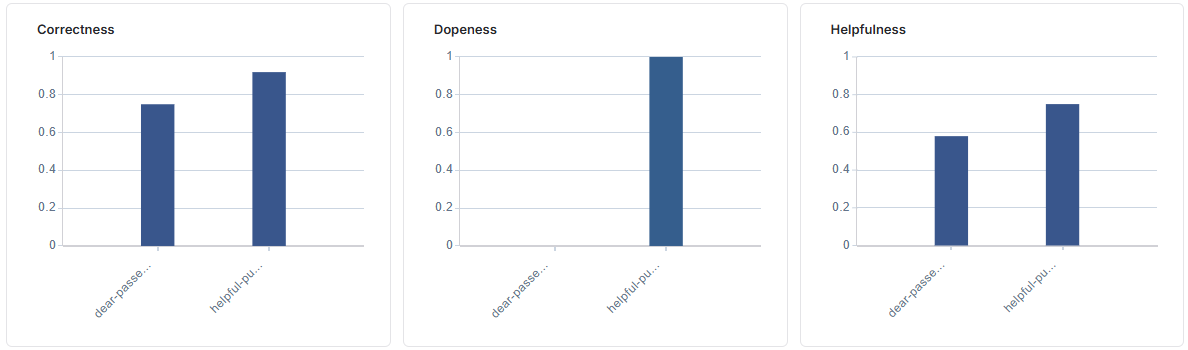

In [38]:
from IPython.display import Image
Image(filename="Screenshot 2025-04-29 133153.png")

The second chain is better across the board. Particularly in dopeness, we see a massive improvement, with the first chain getting a score of zero and the second chain getting a score of one. This makes sense as we changed the prompt to ask the model to reply in a 'dope' way. The improvements to correctness and helpfulness are plausibly due to the increased chunk size, giving the LLM more context with which to answer the question.